In [1]:
""" Import zone """

import math
import html
import datetime

import numpy as np
import pandas as pd
import seaborn as sns

import nltk
from nltk.tokenize import word_tokenize, wordpunct_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer; nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

import spacy; spacy_nlp = spacy.load("en_core_web_sm", disable=['ner', 'entity_linker', 'entity_ruler', 'textcat', 'textcat_multilabel', 'morphologizer', 'senter', 'sentencizer', 'transformer'])

from comodo.comodo.comodo import *

import support
register_consts(support.comodo_config)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tommaso\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
C:\Users\tommaso\AppData\Roaming\Python\Python39\site-packages\statsmodels\compat\pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tommaso\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Done → COMODO.COMODO.CONSTANTS in register_consts() → Comodo's costants correctly configured


In [8]:
""" Lettura DataFrame e piccole modifiche di formato """

# trdf = DF.rcsv('original/drugsComTrain_raw', sep='\t')
# del trdf['Unnamed: 0']
# trdf.columns = ['drug', 'condition', 'review', 'rating', 'date', 'useful']
# trdf['date'] = trdf['date'].apply(lambda d: UTILS.to_datetime(d, '%B %d, %Y', as_str=True))
# trdf = trdf.sort_values('date')

# tsdf = DF.rcsv('original/drugsComTest_raw', sep='\t')
# del tsdf['Unnamed: 0']
# tsdf.columns = ['drug', 'condition', 'review', 'rating', 'date', 'useful']
# tsdf['date'] = tsdf['date'].apply(lambda d: UTILS.to_datetime(d, '%B %d, %Y', as_str=True))

# print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
# print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))

# print('Drop NaN then..', '\n')
# trdf = trdf.dropna()
# tsdf = tsdf.dropna()

# print('Reparir: delete records with "users found this comment helpful *" and add an upper "F" to not-capitalized condition', '\n')
# trdf = DF.add_order_column(trdf)
# tsdf = DF.add_order_column(tsdf)
# trdf = DF.find(trdf, {'order': ['!']+DF.find(trdf, {'condition':['re','users found*']})['order'].to_list()}).copy()
# tsdf = DF.find(tsdf, {'order': ['!']+DF.find(tsdf, {'condition':['re','users found*']})['order'].to_list()}).copy()
# trdf['condition'] = trdf['condition'].apply(lambda c: 'F'+c if c[0].islower() else c)
# tsdf['condition'] = tsdf['condition'].apply(lambda c: 'F'+c if c[0].islower() else c)

# print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
# print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))
# trdf = DF.add_order_column(trdf)
# tsdf = DF.add_order_column(tsdf)

# DF.wcsv(trdf, 'start/train_df.csv', sep='\t')
# DF.wcsv(tsdf, 'start/test_df.csv', sep='\t')

' Lettura DataFrame e piccole modifiche di formato '

<hr style="border: 1px solid orange; background-color: orange">

In [2]:
""" Lettura DataFrame iniziali """

trdf = DF.set_datetime_index(DF.rcsv('start/train_df.csv', sep='\t'), 'date')
tsdf = DF.set_datetime_index(DF.rcsv('start/test_df.csv', sep='\t'), 'date')

print('DF Train shape:  ', trdf.shape, '    NaN:', DF.has_nan(trdf))
print('DF Test shape:   ', tsdf.shape, '     NaN:', DF.has_nan(tsdf))

DF Train shape:   (159498, 7)     NaN: {}
DF Test shape:    (53200, 7)      NaN: {}


In [10]:
""" Descrizione variabili """

print('[drug]       - Total drugs:      ', len(set(trdf['drug'])))
print('[condition]  - Total conditions: ', len(set(trdf['condition'])))
print('[rating]     - Ratings distr.:   ', DICT.filter_key(DF.describe(trdf, 'rating', print_res=False, print_plot=False), lambda k: k in ['mean', 'q25', 'q50', 'q75']))
print('[date]       - Date distr.:      ', {year: trdf[trdf.index.year == year].shape[0] for year in list(set(trdf.index.year))})
print('[useful]     - Useful distr.:    ', DICT.filter_key(DF.describe(trdf, 'useful', print_res=False, print_plot=False), lambda k: k in ['mean', 'q25', 'q50', 'q75', 'max']))

[drug]       - Total drugs:       3412
[condition]  - Total conditions:  811
[rating]     - Ratings distr.:    {'mean': 6.99714729965266, 'q25': 5.0, 'q50': 8.0, 'q75': 10.0}
[date]       - Date distr.:       {2016: 34697, 2017: 28013, 2008: 5011, 2009: 11464, 2010: 8097, 2011: 11308, 2012: 9717, 2013: 12195, 2014: 11969, 2015: 27027}
[useful]     - Useful distr.:     {'mean': 28.19233470012163, 'q25': 6.0, 'q50': 16.0, 'q75': 37.0, 'max': 1291.0}


In [3]:
""" Text preporcessing """

for name,function in OBJECTS._PREPROCESS_STEPS.items():
    print('Applying', name, '..')
    trdf['review'] = trdf['review'].apply(lambda s: function(s))

Applying LOWER ..
Applying NO_QUOTE ..
Applying DECODE_HTML ..
Applying NO_URL ..
Applying NO_EMOJI ..
Applying NO_ESCAPE ..
Applying NO_PUNCTUATION ..
Applying NO_NUMBERS ..
Applying NO_ELLIPSIS ..


<hr style="border: 1px solid orange; background-color: orange">

In [4]:
""" Sentence and word tokenization + POS Tagging """

# all_sentences = [sent_tokenize(review) for review in trdf['review']]
# all_words = [[word_tokenize(sentence) if len(sentence)>0 else '' for sentence in sentences] for sentences in all_sentences]
# all_pos_tag = [[nltk.pos_tag(words) for words in sentence] for sentence in all_words]

# _ = UTILS.pkl_save('pkl/all_sentences', all_sentences)
# _ = UTILS.pkl_save('pkl/all_words', all_words)
# _ = UTILS.pkl_save('pkl/all_pos_tag', all_pos_tag)

all_sentences = UTILS.pkl_load('pkl/all_sentences')
all_words = UTILS.pkl_load('pkl/all_words')
all_pos_tag = UTILS.pkl_load('pkl/all_pos_tag')

In [5]:
""" Filtering by POS Tag (N+J+V+R) -Stopwords """

lemmatizer = spacy_nlp.get_pipe("lemmatizer")
all_sentences_NJVR_lemmatized = []

for iR,review in enumerate(all_pos_tag):
    entry_review = []
    for iS,sentence in enumerate(review):
        entry_sentence = []
        
        # FILTER NJVR -STOPWORDS
        [entry_sentence.append(spacy_nlp(word[0])[0].lemma_) for word in sentence if word[1] in OBJECTS._POS_TAG['TO_KEEP'] and word[1] not in OBJECTS._STOPWORDS]
        
        entry_review.append(entry_sentence)
    all_sentences_NJVR_lemmatized.append(entry_review)

In [7]:
""" Back to Dataset """

trdf['clean_review'] = trdf.apply(lambda r: '|'.join([' '.join(sentence) for sentence in all_sentences_NJVR_lemmatized[r['order']]]), axis = 1)
trdf.head(3)

,drug,condition,review,rating,date,useful,order,prep_review
date,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,1.0,2008-02-24,0,0,medical clinic flu symptom Dr. duty prescribe ...
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,7.0,2008-02-24,22,1,improve problem dramatically|never experience ...
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,7.0,2008-02-24,50,2,xenical really help bowel problem have make ma...


In [ ]:
""" SPACY Lemmatization """

trdf['prep_review'] = trdf['clean_review'].apply(lambda review: '|'.join([' '.join([spacy_nlp(word)[0].lemma_ for word in sentence.split()]) for sentence in review.split('|')]))
trdf.head(3)

<hr style="border: 1px solid orange; background-color: orange">

In [55]:
""" Starts with preprocessed datafarame """

step = 'prep'
trdf = DF.set_datetime_index(DF.rcsv(step+'/train_df.csv', sep='\t'), 'date')
trdf.head(3)

,drug,condition,review,rating,date,useful,order,clean_review,prep_review
date,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,1.0,2008-02-24,0,0,i medical clinic flu symptoms dr. duty prescri...,I medical clinic flu symptom dr duty prescribe...
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,7.0,2008-02-24,22,1,improved problem dramatically|i never experien...,improve problem dramatically|I never experienc...
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,7.0,2008-02-24,50,2,xenical really helped bowel problems i had mad...,xenical really help bowel problem I have make ...


In [56]:
""" Vocabulary """

all_vocab = []
_ = [[[all_vocab.append(w) for w in s.split()] if type(s) is str else '' for s in r.split('|')] if type(r) is str else '' for r in trdf['prep_review'].to_list()]
vocab = set(all_vocab)
vocab_occurrences = LIST.occurrences(all_vocab)
print('Vocab length:', len(vocab))

all_vocab_original = []
_ = [[all_vocab_original.append(w) if type(w) is str else '' for w in r.split(' ')] if type(r) is str else '' for r in trdf['review'].to_list()]
vocab_original = set(all_vocab_original)
vocab_original_ccurrences = LIST.occurrences(all_vocab_original)
print('Original vocab length:', len(vocab_original))

Vocab length: 37732
Original vocab length: 61580


In [57]:
""" Vocabulary Analysis"""

print('Reviews containg dot "." :', sum(list(DICT.dfilter(vocab_occurrences, lambda x: '.' in x).values())))
print('Drop all them → keep at least', str(100*(trdf.shape[0]-9000)/DF.rcsv('start/train_df.csv', sep='\t').shape[0]), '% of total')
trdf = DF.find_lambda(trdf, lambda r: '.' not in r['prep_review'] if type(r['prep_review'])is str else False)
trdf['prep_review'] = trdf['prep_review'].apply(lambda r: r.lower())
print('Now size:', trdf.shape)

Reviews containg dot "." : 9000
Drop all them → keep at least 91.62873515655369 % of total
Now size: (148256, 9)


In [58]:
""" Write DF ready for Analysis """

del trdf['clean_review']    # Non serve più, non è la definitiva
del trdf['order']           # Non congruente dopo clean finale

trdf.rename(columns={'review': 'original_review', 'prep_review': 'review'}, inplace=True)

trdf['review'] = trdf['review'].apply(lambda r: r.lower())
# Forme negative -> replace 'not# ' per tenerle | 'not' per convertire tutto in not | '' per eliminarle
trdf['review'] = trdf['review'].apply(lambda r: '|'.join([' '.join(LIST.lfilter([w if w not in OBJECTS._NEG_STOPWORDS else 'not#' for i,w in enumerate(s.split()) if w not in OBJECTS._STOPWORDS or (w in OBJECTS._STOPWORDS and w in OBJECTS._NEG_STOPWORDS)], lambda w:w!='')).replace('# ', '_') for s in r.split('|')]))

trdf['review_words'] = trdf['review'].apply(lambda r: ' '.join([' '.join(s.split()) for s in r.split('|')]))

trdf = DF.add_order_column(trdf)

trdf = trdf[['drug', 'condition', 'original_review', 'review', 'review_words', 'rating', 'useful', 'date', 'order']]

DF.wcsv(trdf, 'analysis/train_df.csv', sep='\t')

<hr style="border: 1px solid orange; background-color: orange">

In [59]:
""" Read DF for analysis """

trdf = DF.set_datetime_index(DF.rcsv('analysis/train_df.csv', sep='\t'), 'date')
trdf.head(10)

,drug,condition,original_review,review,review_words,rating,useful,date,order
date,,,,,,,,,
2008-02-24,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,i when to a medical clinic with flu like sympt...,medical clinic flu symptom dr duty prescribe d...,medical clinic flu symptom dr duty prescribe d...,1.0,0,2008-02-24,0
2008-02-24,Oxybutynin,Not Listed / Othe,improved my problem dramatically. i never expe...,improve problem dramatically|never experience ...,improve problem dramatically never experience ...,7.0,22,2008-02-24,1
2008-02-24,Xenical,Obesity,xenical really helped me but some of the bowel...,xenical really help bowel problem make margina...,xenical really help bowel problem make margina...,7.0,50,2008-02-24,2
2008-02-24,Macrobid,Bladder Infection,excellent for prevention of bladder infection ...,excellent prevention bladder infection cns com...,excellent prevention bladder infection cns com...,8.0,52,2008-02-24,3
2008-02-24,Orlistat,Obesity,xenical really helped me but some of the bowel...,xenical really help bowel problem make margina...,xenical really help bowel problem make margina...,7.0,50,2008-02-24,4
2008-02-25,Fentanyl,Pain,i don t think i could make it without the patc...,not_think make patch|pain back point live|fent...,not_think make patch pain back point live fent...,10.0,22,2008-02-25,5
2008-02-25,Humira,"Crohn's Disease, Maintenance",my name is serena. i have had chron s disease ...,name serena|chron disease year|surgery year ag...,name serena chron disease year surgery year ag...,10.0,111,2008-02-25,6
2008-02-25,Buprenorphine,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,7
2008-02-25,Methylphenidate,ADHD,my son was taking the mg for yrs when all of a...,son take mg yrs sudden start get severely depr...,son take mg yrs sudden start get severely depr...,5.0,159,2008-02-25,8


In [60]:
""" Remove condtions under 35 reviews """

keep_condition = list(DICT.dfilter(LIST.occurrences(trdf['condition']), by='value', lambda_fun=lambda v: v>=35).keys())
trdf = DF.find(trdf, {'condition': keep_condition})

print('Now size:', trdf.shape[0])
print('Kept conditions:', len(keep_condition))

Now size: 148099
Kept conditions: 249


In [61]:
""" Raggruppo per condizione """

gr_condition = trdf.groupby('condition')
grc = gr_condition.get_group('Opiate Dependence')

<hr>

In [65]:
DF.find_lambda(grc, lambda r: 'not_' in r['review_words'] and 'not_not' not in r['review_words'])['review_words'].values[20:30]

array(['addict percocet lortab morphine ir oxycodone almost year horrible accident feed feel shit day run medicine not_wait make excuse pain doctor get pill monday live die choose live go doctor tell want change refer specialist addiction give mg suboxone immediately arrival severe withdrawal hour later feel alive not_mean high mean alive withdrawal completely go craving nothing lose everything life suboxone miracle',
       'know people keep say bad suboxone withdrawal really not_bad comparison hard opiate year experience notice withdrawal symptom largely head know people never withdrawal symptom simply not_think slowly taper suboxone month try take later later day push wait hour take small amt stay busy boredom make relapse exercise take vitamin eat healthy good idea start thing attempt stop suboxone',
       'year old kid addict vicodin percocet everyday wake wait phone find pill day not_take care kid bad panic not_find anything take kid fault addict year need start get sick bad wit

<hr>

In [7]:
""" Filter Luhn Analysis """

def get_vocab(df, text_col='review_words'):
    all_vocab = []
    _ = [[all_vocab.append(w) for w in r.split()] for r in df[text_col].to_list() if type(r) is str]
    vocab_occurrences = LIST.occurrences(all_vocab)
    return vocab_occurrences

# Distribution of log-corrected vocab occurrencies
vocab = get_vocab(grc)
vocab_log = DICT.apply_value(vocab, lambda f: round(UTILS.log(f), ndigits=1))
vocab_log_distr = LIST.describe(vocab_log.values(), print_res=False, print_plot=False)

# Keep from floor(skewness) to max-ceil(skewness)
l_cutoff, u_cutoff = round(vocab_log_distr['skewness']), int(vocab_log_distr['max'])-math.ceil(vocab_log_distr['skewness'])
keep_vocab = list(DICT.filter_value(vocab_log, lambda l: l_cutoff <= l and l <= u_cutoff).keys())

# Filter luhn words
grc['review_words_luhn'] = grc['review_words'].apply(lambda r: ' '.join([w for w in r.split() if w in keep_vocab]) if type(r) is str else ' ')

C:\Users\tommaso\AppData\Local\Temp/ipykernel_17380/680090272.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc['review_words_luhn'] = grc['review_words'].apply(lambda r: ' '.join([w for w in r.split() if w in keep_vocab]) if type(r) is str else ' ')


In [128]:
""" TF-IDF Representation of one condition group """
from sklearn.feature_extraction.text import TfidfVectorizer

grc = grc.dropna()
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(grc['review_words_luhn'])
tv_matrix = tv_matrix.toarray()

tfidf_df = pd.DataFrame(np.round(tv_matrix, 2), columns=tv.get_feature_names())

tfidf_df.head(2)

,abilify,ability,able,abnormal,absolute,absolutely,absorb,absorption,abuse,acceptable,...,zaleplon,zero,zilch,zoloft,zolpidem,zombie,zone,zopiclone,zyprexa,zzzquil
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<hr>
<h3>KMEANS</h3>

In [131]:
from sklearn.cluster import KMeans
#setup kmeans clustering
kmeans = KMeans(n_clusters = 5, n_init = 20, n_jobs = -1, tol = 0.01, max_iter = 200)
#fit the data 
kmeans.fit(tv_matrix)
#this loop transforms the numbers back into words
words = tv.get_feature_names()
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\cluster\_kmeans.py:792: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 1.0 (renaming of 0.25).
  warnings.warn("'n_jobs' was deprecated in version 0.23 and will be"


0 : seroquel, gain, weight, eat, pound, lb, appetite, remeron, much, keep
1 : effective, find, less, urinate, change, experience, able, life, dose, relax
2 : stay, trouble, problem, refresh, need, able, much, awake, thing, people
3 : find, need, really, thing, nothing, put, dose, life, trazodone, much
4 : awake, tired, last, wide, even, pm, silenor, really, minute, later


<hr>
<h3>LSA e LDA</h3>

In [ ]:
""" WordCloud """

# Import the wordcloud library
from wordcloud import WordCloud
long_string = ','.join(LIST.lfilter(list(grc['review_words_luhn'].values), lambda v: type(v) is str)) 
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue', width=800, height=400)
wordcloud.generate(long_string)
wordcloud.to_image()

In [7]:
""" LSA """
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances

k = 10
svd_model = TruncatedSVD(n_components=k, algorithm='randomized', n_iter=100, random_state=420)
lsa = svd_model.fit_transform(tv_matrix)

topic_df = pd.DataFrame(lsa, columns = ["topic_"+str(i) for i in range(k)])
print(topic_df.shape)
topic_df.head(2)

#PRINTING TOPICS

terms = tv.get_feature_names()
for i, comp in enumerate(svd_model.components_):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:10]
    
    topic_terms = ''
    for t in sorted_terms:
        topic_terms += (t[0] if t[1]>0.03 else '') + ' '
    print("Topic ", str(i)+': ', topic_terms)

In [ ]:
""" LDA """

import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim.corpora import Dictionary

grc_dictionary = Dictionary(LIST.applyf(grc['review_words_luhn'].to_list(), lambda s: s.split() if type(s) is str else []))
grc_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

bow_corpus = [grc_dictionary.doc2bow(doc) for doc in LIST.applyf(grc['review_words_luhn'].to_list(), lambda s: s.split() if type(s) is str else [])]

# Create lda model with gensim library
# Manually pick number of topic
lda_model = gensim.models.LdaModel( bow_corpus,
                                    id2word = grc_dictionary,
                                    num_topics = 4,
                                    offset = 2,
                                    random_state = 100,
                                    update_every = 0,
                                    passes = 10,
                                    alpha = 0.001,
                                    eta = 2,
                                    per_word_topics = False )

from pprint import pprint
pprint(lda_model.print_topics())


<hr>
<h3>Word2Vec</h3>

In [8]:
""" POS dict """
pos_dict = UTILS.pkl_load('pkl/pos_dict.pkl')

In [9]:
""" W2V model """
w2v_model = UTILS.pkl_load('pkl/w2v_sg_mc10.pkl')
w2v_vocab = w2v_model.wv.key_to_index

In [10]:
grc.iloc[0]['review']

'work great really ready stop take opiate'

In [11]:
""" Cerca costrutti grammaticali """

jn_constr = ('J', 'N')      # aggettivo  +  nome            # conoscienza comune
vj_constr = ('V', 'J')      # verbo      +  aggettivo       # https://www.grammarly.com/blog/adjective-and-verb-placement/#:~:text=Adjectives%20are%20usually%20placed%20before,are%20placed%20after%20the%20verb.&text=%E2%80%9CSense%E2%80%9D%20verbs%2C%20such%20as,The%20cookies%20smell%20awesome%20!
rj_constr = ('R', 'J')      # avverbio   +  aggettivo       # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
rv_constr = ('R', 'V')      # avverbio   +  verbo           # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
vr_constr = ('V', 'R')      # verbo      +  avverbio           # https://site.uit.no/english/grammar/adverb-placement/#:~:text=Adverbs%20can%20be%20used%20to,%2C%20recently%20re%2Delected%20president.
grammar_constrs = [jn_constr, vj_constr, rj_constr, rv_constr, vr_constr]

def get_biConstrcut(sentence, construct):
    constructs = []
    if type(sentence) is str:
        words = sentence.split()
        _ = [constructs.append([w, words[i+1]]) for i,w in enumerate(words[:-1]) if w in pos_dict and pos_dict[w][0]==construct[0] and words[i+1] in pos_dict and pos_dict[words[i+1]][0]==construct[1]]
    return constructs

def sentences_biContruct(sentences, construct, to_str=False):
    constr_list = []
    if type(sentences) is str:
        _ = [[constr_list.append(c) for c in sc] for sc in LIST.lfilter([get_biConstrcut(s, construct) for s in sentences.split('|')], lambda v: len(v)>0)]
    if to_str:
        return '|'.join([' '.join(w) for w in constr_list])
    else:
        return constr_list

for grammar_constr in grammar_constrs:
    column_name = grammar_constr[0].lower()+grammar_constr[1].lower()+'_'+'constr'
    grc[column_name] = grc['review'].apply(lambda review: sentences_biContruct(review, grammar_constr, to_str=True))
grc.head(40)

C:\Users\tommaso\AppData\Local\Temp/ipykernel_17380/3650881418.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc[column_name] = grc['review'].apply(lambda review: sentences_biContruct(review, grammar_constr, to_str=True))
C:\Users\tommaso\AppData\Local\Temp/ipykernel_17380/3650881418.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc[column_name] = grc['review'].apply(lambda review: sentences_biContruct(review, grammar_constr, to_str=True))
C:\Users\tommaso\AppData\Local\Temp/ipykernel_17380/36

,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,jn_constr,vj_constr,rj_constr,rv_constr,vr_constr
date,,,,,,,,,,,,,,,
2008-02-25,Buprenorphine,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,7,really ready,,,,really ready|stop take,ready stop
2008-02-25,Subutex,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,14,really ready,,,,really ready|stop take,ready stop
2008-02-26,Suboxone,Opiate Dependence,me and a friend have been hooked for about yea...,friend hooked year narco hydrocodine go weeken...,friend hooked year narco hydrocodine go weeken...,10.0,30,2008-02-26,25,friend hooked weekend together clinic much sug...,,,together clinic,,
2008-03-02,Suboxone,Opiate Dependence,i had an year addiction to norco vicodin follo...,year addiction norco vicodin follow extensive ...,year addiction norco vicodin follow extensive ...,10.0,162,2008-03-02,116,norco vicodin follow extensive surgery bit end...,,bit bullet,,suboxone end,take suboxone|renew suboxone
2008-03-03,Buprenorphine / naloxone,Opiate Dependence,thank god for this medication after years of t...,thank god medication year take script pain thi...,thank god medication year take script pain thi...,9.0,33,2008-03-03,128,thank god script really quit almost sick crave...,,,,god medication,think really
2008-03-06,Suboxone,Opiate Dependence,i have been taking suboxone for ten months now...,take suboxone ten month let tell serious want ...,take suboxone ten month let tell serious want ...,10.0,109,2008-03-06,173,ten let tell serious quit follow order anythin...,ten month|serious want,back old,suboxone ten|tell serious|quit addiction,quit use|really back,take suboxone|mg oxycontin|use suboxone|take r...
2008-03-06,Buprenorphine / naloxone,Opiate Dependence,i have been taking suboxone for ten months now...,take suboxone ten month let tell serious want ...,take suboxone ten month let tell serious want ...,10.0,109,2008-03-06,183,ten let tell serious quit follow order anythin...,ten month|serious want,back old,suboxone ten|tell serious|quit addiction,quit use|really back,take suboxone|mg oxycontin|use suboxone|take r...
2008-03-25,Buprenorphine / naloxone,Opiate Dependence,it sounds magical even to me but i can assure ...,sound magical even assure real case least subo...,sound magical even assure real case least subo...,10.0,330,2008-03-25,481,sound even real case least cure illegal depend...,real case|drive ghetto|therapy way|new job|sav...,cure illegal,sound magical|get heroin|suboxone therapy|get ...,suboxone cure,
2008-03-25,Suboxone,Opiate Dependence,it sounds magical even to me but i can assure ...,sound magical even assure real case least subo...,sound magical even assure real case least subo...,10.0,330,2008-03-25,483,sound even real case least cure illegal depend...,real case|drive ghetto|therapy way|new job|sav...,cure illegal,sound magical|get heroin|suboxone therapy|get ...,suboxone cure,


In [12]:
import scipy

def nbgdist(w2v_model, bgs1, bgs2):
    ngvec1 = [bgvec(w2v_model, bg) for bg in bgs1]
    ngvec2 = [bgvec(w2v_model, bg) for bg in bgs2]
    return 1-scipy.spatial.distance.cosine(np.mean(ngvec1, axis=0), np.mean(ngvec2, axis=0))

def bgdist(w2v_model, bg1, bg2):
    gvec1 = bgvec(w2v_model, bg1)
    gvec2 = bgvec(w2v_model, bg2)
    return 1-scipy.spatial.distance.cosine(gvec1, gvec2)

def bgvec(w2v_model, bg):
    vecs = tuple([ML.wvec(w2v_model,g) for g in bg])
    return np.concatenate(vecs)

def all_bigram(review, bigram_cols):
    all_bg = []
    if (False in [review[col]=='' for col in bigram_cols]):
        for bigram_col in bigram_cols:
            if review[bigram_col]!='':
                _ = [all_bg.append(bi.split()) for bi in review[bigram_col].split('|') if bi.split()[0] in w2v_vocab and bi.split()[1] in w2v_vocab]
    return all_bg


In [14]:
grc#.head(30)

,drug,condition,original_review,review,review_words,rating,useful,date,order,review_words_luhn,jn_constr,vj_constr,rj_constr,rv_constr,vr_constr
date,,,,,,,,,,,,,,,
2008-02-25,Buprenorphine,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,7,really ready,,,,really ready|stop take,ready stop
2008-02-25,Subutex,Opiate Dependence,it s works great if your really ready to stop ...,work great really ready stop take opiate,work great really ready stop take opiate,8.0,78,2008-02-25,14,really ready,,,,really ready|stop take,ready stop
2008-02-26,Suboxone,Opiate Dependence,me and a friend have been hooked for about yea...,friend hooked year narco hydrocodine go weeken...,friend hooked year narco hydrocodine go weeken...,10.0,30,2008-02-26,25,friend hooked weekend together clinic much sug...,,,together clinic,,
2008-03-02,Suboxone,Opiate Dependence,i had an year addiction to norco vicodin follo...,year addiction norco vicodin follow extensive ...,year addiction norco vicodin follow extensive ...,10.0,162,2008-03-02,116,norco vicodin follow extensive surgery bit end...,,bit bullet,,suboxone end,take suboxone|renew suboxone
2008-03-03,Buprenorphine / naloxone,Opiate Dependence,thank god for this medication after years of t...,thank god medication year take script pain thi...,thank god medication year take script pain thi...,9.0,33,2008-03-03,128,thank god script really quit almost sick crave...,,,,god medication,think really
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-03,Buprenorphine / naloxone,Opiate Dependence,i finally checked myself into a clinic after y...,finally check clinic year|chronic pain issue t...,finally check clinic year chronic pain issue t...,10.0,0,2017-11-03,145949,finally check clinic chronic issue anymore per...,clinic year|pa insurance|new person,check clinic|awful wd|flavor pleasant,free wait|decide wait|uncontrollably shake|anx...,finally check|anymore mg|highly recommend,take anymore|medication anxiety|recommend far
2017-12-02,Vivitrol,Opiate Dependence,i cannot express enough how incredible vivitro...,express enough incredible vivitrol proud say m...,express enough incredible vivitrol proud say m...,10.0,2,2017-12-02,147788,enough incredible vivitrol proud say vivitrol ...,say month|craving substance,recommend everybody,go vivitrol|self destructive|never able|live s...,still suffer,spend self|keep go
2017-12-02,Naltrexone,Opiate Dependence,i cannot express enough how incredible vivitro...,express enough incredible vivitrol proud say m...,express enough incredible vivitrol proud say m...,10.0,2,2017-12-02,147795,enough incredible vivitrol proud say vivitrol ...,say month|craving substance,recommend everybody,go vivitrol|self destructive|never able|live s...,still suffer,spend self|keep go


# Describe variable: values

• n obs :   2909
• mean :   2.7308588786746073
• variance :   10.45288144236197
• std :   3.155244725637796
• min :   0.0
• q25 :   0.0
• q50 :   1.0
• q75 :   5.0
• max :   10.0
• range :   10.0
• skewness :   0.873823970651357
• kurtosis :   -0.492789044191253




{'n obs': 2909,
 'mean': 2.7308588786746073,
 'variance': 10.45288144236197,
 'std': 3.155244725637796,
 'min': 0.0,
 'q25': 0.0,
 'q50': 1.0,
 'q75': 5.0,
 'max': 10.0,
 'range': 10.0,
 'skewness': 0.873823970651357,
 'kurtosis': -0.492789044191253}

<Figure size 432x288 with 0 Axes>

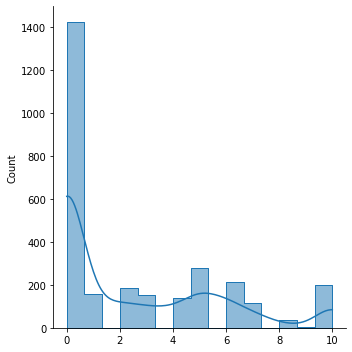

In [29]:
LIST.describe([10*DF.find_lambda(DF.find(trdf, {'drug':d}), lambda r: d.lower() in r['original_review'].lower()).shape[0] / DF.find(trdf, {'drug':d}).shape[0] for d in list(set(trdf['drug']))])

In [11]:
one_bigram_for_all = grc.apply(lambda r: all_bigram(r, ['jn_constr', 'vj_constr', 'rj_constr', 'rv_constr', 'vr_constr']), axis=1)

no_empty_idxs = [i for i in range(len(one_bigram_for_all.to_list())) if one_bigram_for_all[i]!=[]]
one_bigram_for_all_noempty = LIST.lfilter(one_bigram_for_all.to_list(), lambda l:l!=[])
one_bigram_for_all_noempty_mean = [np.mean([bgvec(w2v_model,bg) for bg in bgs], axis=0) for bgs in one_bigram_for_all_noempty]

print("Analysis on the "+ str(len(one_bigram_for_all_noempty_mean)/grc.shape[0]*100) + " of condition dataset")

Analysis on the 95.91633466135458 of condition dataset


In [22]:
# dist_mat = ML.dist_matrix(one_bigram_for_all_noempty, lambda_fun=lambda bgs1,bgs2: nbgdist(w2v_model,bgs1,bgs2))
# dist_mat=UTILS.pkl_load('pkl/dist_mat_noempty.pkl')
# sorted_dist_mat = ML.sort_dist_matrix(dist_mat['matrix'], method='complete', initial_values=no_empty_idxs, norm=True)
# cl = ML.dm_cluster(sorted_dist_mat['sorted_dist_matrix'], no_empty_idxs, eps=0.4)

NameError: name 'dist_mat' is not defined

In [12]:
from sklearn.cluster import AgglomerativeClustering

agcl_model = AgglomerativeClustering(n_clusters=7, affinity='precomputed', linkage='complete')
agcl = agcl_model.fit(dist_mat['matrix'])

link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs, list(agcl.labels_))}
grc['agglomerative_label'] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

# LIST.describe(list(agcl.labels_))

NameError: name 'dist_mat' is not defined

In [13]:
from sklearn.mixture import GaussianMixture

gm_model = GaussianMixture(n_components=7, random_state=0).fit(one_bigram_for_all_noempty_mean)
gm = gm_model.predict(one_bigram_for_all_noempty_mean)

# LIST.describe(list(gm))

link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs, gm)}
grc['mixture_label'] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]

C:\Users\tommaso\AppData\Local\Temp/ipykernel_15084/803944122.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc['mixture_label'] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]


C:\Users\tommaso\AppData\Local\Temp/ipykernel_15084/1886913702.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc['kmeans_label'] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]
C:\Users\tommaso\AppData\Local\Temp/ipykernel_15084/1886913702.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grc['kmeans_dist'] = [np.linalg.norm(km_model.cluster_centers_[link_back[order]] - np.mean([bgvec(w2v_model,bg) for bg in one_bigram_for_all[order]],axis=0)) if order in link_ba

# Describe variable: rating

• n obs :   35
• mean :   9.8
• variance :   0.28235294117647053
• std :   0.5313689313240572
• min :   8.0
• q25 :   10.0
• q50 :   10.0
• q75 :   10.0
• max :   10.0
• range :   2.0
• skewness :   -2.577698828412665
• kurtosis :   5.458333333333348




<Figure size 2160x504 with 0 Axes>

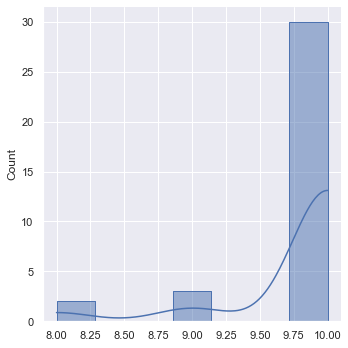

In [37]:
from sklearn.cluster import KMeans

km_model = KMeans(n_clusters=3, random_state=666)
kmcl = km_model.fit(one_bigram_for_all_noempty_mean)

# LIST.describe(list(km_model.labels_))

link_back = {doc_order: label for doc_order,label in zip(no_empty_idxs, list(km_model.labels_))}
grc['kmeans_label'] = [link_back[order] if order in link_back else -1 for order in range(grc.shape[0])]
grc['kmeans_dist'] = [np.linalg.norm(km_model.cluster_centers_[link_back[order]] - np.mean([bgvec(w2v_model,bg) for bg in one_bigram_for_all[order]],axis=0)) if order in link_back else -1 for order in range(grc.shape[0])]
_ = DF.describe(DF.find(grc, {'kmeans_label':0}), 'rating', print_res=True)

C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\relational.py:651: UserWarning: You passed a edgecolor/edgecolors ('w') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the futu

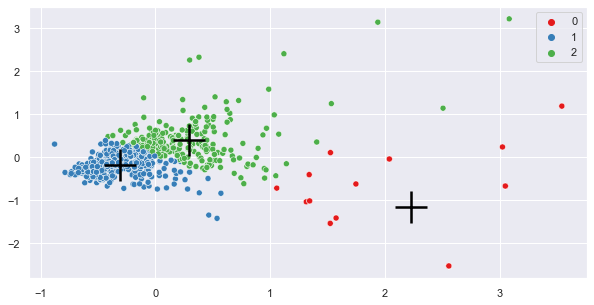

In [15]:
# PCA per fare del bello
from sklearn.decomposition import PCA

pca_model = PCA(n_components=2).fit(one_bigram_for_all_noempty_mean)
one_bigram_for_all_noempty_mean_pca = pca_model.transform(one_bigram_for_all_noempty_mean)
cl_centers_pca = pca_model.transform(km_model.cluster_centers_)

MODULES.set_sns_fsize((10,5))
sns.scatterplot(one_bigram_for_all_noempty_mean_pca[:,0], one_bigram_for_all_noempty_mean_pca[:,1], hue=LIST.lfilter(grc['kmeans_label'].to_list(), lambda l:l>-1), palette=sns.color_palette("Set1", n_colors=3));
sns.scatterplot(cl_centers_pca[:,0], cl_centers_pca[:,1], marker='+', color='black', s=1000);

<AxesSubplot:xlabel='drug', ylabel='Count'>

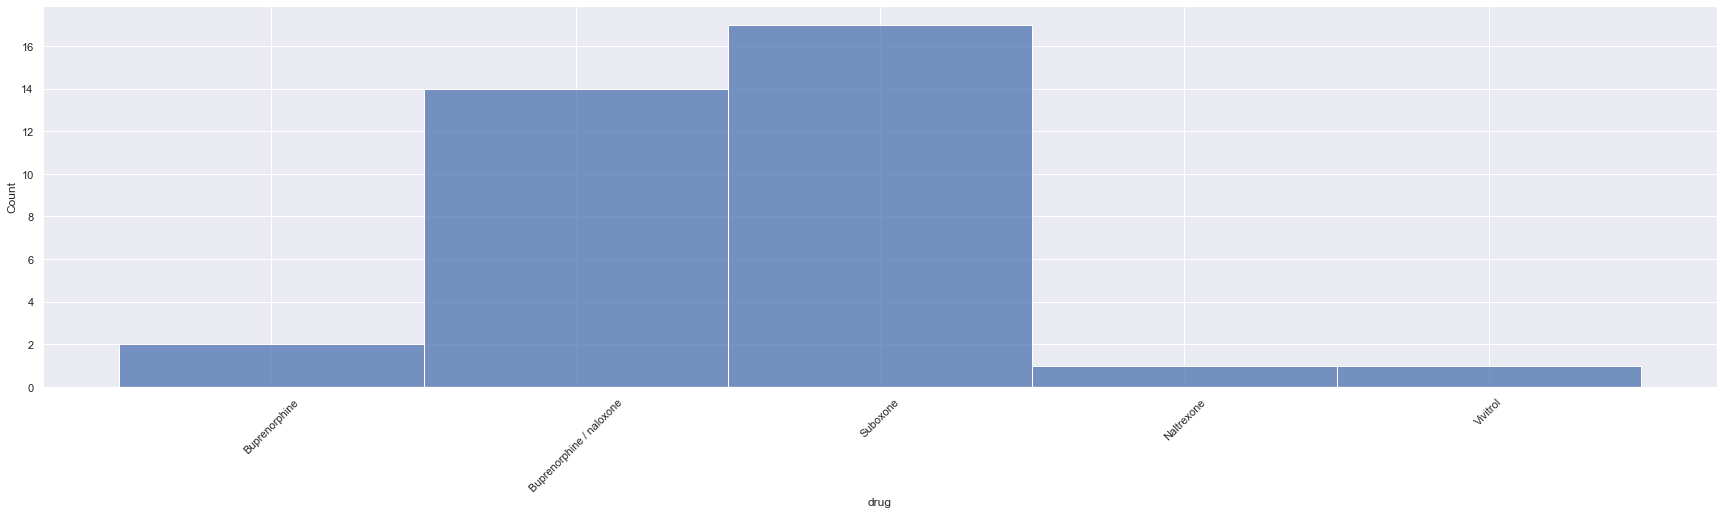

In [16]:
MODULES.set_sns_fsize((30,7))
PLOT.plt.xticks(rotation=45)
sns.histplot(DF.find(grc, {'kmeans_label':0}), x='drug')

In [34]:
for icl in range(3):
    print('• Cluster',str(icl),':\n-','\n- '.join(DF.find(grc, {'kmeans_label':icl}).sort_values('kmeans_dist', ascending=False).iloc[[2,4,6,8]]['original_review'].to_list()))
    if icl<3:
        print()


• Cluster 0 :
- i m on vivitrol and i have no side effects and i m doing fabulous i have no desire to use i was an iv user for years and vivitrol saving my life
- i just started treatment with suboxone yesterday. i was in full wd hrs in. hour after the doctor gave me my first dose. the wd eased up drastically. i cannot believe that there is something out there that can help like this does. probably saved my marriage and my life.
- saved my life. saved my family. find a doctor that understands addiction and take the step. it works.
- it has saved my life

• Cluster 1 :
- dr. gave me a script of this because the first one is free from the maker. works just fine.
- i have been on suboxone for days now i have yet to crave a norco. i was taking a day for the last yrs. i had major back surgery. i have no complaints as of yet
- this medication has changed my life welcome world
- in a hole have nothing or no one that was me. on a plan with this and changing my life if you want to change you ca

In [18]:
""" TF-IDF Representation of one condition group """
from sklearn.feature_extraction.text import TfidfVectorizer

cldf = DF.find(grc, {'kmeans_label':1})
tv = TfidfVectorizer(min_df=0., max_df=1., use_idf=True)
tv_matrix = tv.fit_transform(cldf['review_words_luhn'])
tv_matrix = tv_matrix.toarray()

tfidf_df = pd.DataFrame(np.round(tv_matrix, 2), columns=tv.get_feature_names())

tfidf_df.head(5)

,abdominal,able,absolute,absolutely,absorb,absorption,abstinence,abuse,abuser,accept,...,ya,yes,yesterday,yet,young,yr,yrs,zero,zub,zubsolv
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
import gensim
from gensim.test.utils import common_corpus, common_dictionary
from gensim.corpora import Dictionary

cldf_dictionary = Dictionary(LIST.applyf(cldf['review_words_luhn'].to_list(), lambda s: s.split() if type(s) is str else []))
cldf_dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

bow_corpus = [cldf_dictionary.doc2bow(doc) for doc in LIST.applyf(cldf['review_words_luhn'].to_list(), lambda s: s.split() if type(s) is str else [])]

# Create lda model with gensim library
# Manually pick number of topic
lda_model = gensim.models.LdaModel( bow_corpus,
                                    id2word = cldf_dictionary,
                                    num_topics = 3,
                                    offset = 2,
                                    random_state = 100,
                                    update_every = 0,
                                    passes = 10,
                                    alpha = 'auto',
                                    eta = 'auto',
                                    per_word_topics = False )

from pprint import pprint
pprint(lda_model.print_topics())

[(0,
  '0.011*"finally" + 0.010*"ever" + 0.010*"much" + 0.009*"almost" + '
  '0.009*"never" + 0.009*"thank" + 0.009*"last" + 0.008*"vivitrol" + '
  '0.008*"side" + 0.008*"relapse"'),
 (1,
  '0.012*"subutex" + 0.012*"also" + 0.011*"medicine" + 0.010*"craving" + '
  '0.010*"side" + 0.009*"effect" + 0.009*"people" + 0.009*"need" + '
  '0.009*"high" + 0.008*"dose"'),
 (2,
  '0.016*"hour" + 0.013*"tell" + 0.013*"dose" + 0.011*"sub" + 0.010*"even" + '
  '0.010*"last" + 0.009*"say" + 0.008*"never" + 0.008*"zubsolv" + '
  '0.007*"subutex"')]


In [20]:
import pyLDAvis.gensim_models
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_data_filepath = os.path.join(PATHS._BASE_DIR+'lda_viz'+str(5))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:
    LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, bow_corpus, cldf_dictionary)
    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)

# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath, 'rb') as f:
    LDAvis_prepared = pickle.load(f)
pyLDAvis.save_html(LDAvis_prepared, PATHS._BASE_DIR+'lda_viz' + str(5) +'.html')
LDAvis_prepared

C:\Users\tommaso\AppData\Roaming\Python\Python39\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.084590  0.040344       1        1  34.873561
1     -0.005145 -0.089070       2        1  33.730205
2     -0.079445  0.048726       3        1  31.396234, topic_info=         Term       Freq      Total Category  logprob  loglift
173      hour  98.000000  98.000000  Default  30.0000  30.0000
702  dissolve  32.000000  32.000000  Default  29.0000  29.0000
598       sub  69.000000  69.000000  Default  28.0000  28.0000
691   zubsolv  53.000000  53.000000  Default  27.0000  27.0000
21    subutex  90.000000  90.000000  Default  26.0000  26.0000
..        ...        ...        ...      ...      ...      ...
35    symptom  23.678709  58.777636   Topic3  -5.1728   0.2493
214    people  25.930246  74.668384   Topic3  -5.0819   0.1008
89       free  20.686323  48.355702   Topic3  -5.3079   0.3094
76      detox  23.212561  71.061830   Topic3  -5.1926   0.0396
145     thing  22.027987  78.666499   Topic3  -5.2450  -0.1144

[241 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
27        1  0.796474        able
27        2  0.028445        able
27        3  0.142227        able
695       3  0.930463      absorb
709       2  0.116344  absorption
...     ...       ...         ...
475       2  0.056875         yrs
475       3  0.227498         yrs
691       1  0.018830     zubsolv
691       2  0.376599     zubsolv
691       3  0.602559     zubsolv

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3])

<hr>

In [39]:
OBJECTS._STOPWORDS

['down',
 'than',
 'until',
 'you',
 'those',
 'but',
 'there',
 'theirs',
 'i',
 'yourselves',
 'he',
 'both',
 'won',
 't',
 "won't",
 'all',
 'had',
 'here',
 'haven',
 'off',
 'too',
 "mightn't",
 'we',
 'nor',
 'that',
 'few',
 'were',
 'above',
 'in',
 'other',
 "couldn't",
 'been',
 'because',
 'needn',
 "wasn't",
 'doesn',
 'through',
 'of',
 'during',
 "don't",
 "that'll",
 'does',
 'wouldn',
 'where',
 "shouldn't",
 'ourselves',
 'which',
 'when',
 'no',
 'hasn',
 'about',
 'after',
 'to',
 "doesn't",
 "mustn't",
 "shan't",
 'll',
 'most',
 'herself',
 'her',
 'any',
 "hadn't",
 'wasn',
 'your',
 'such',
 'couldn',
 'same',
 "isn't",
 'will',
 'what',
 'a',
 'are',
 'didn',
 'myself',
 'should',
 'be',
 'on',
 "wouldn't",
 'y',
 'mustn',
 'before',
 'am',
 'shouldn',
 'him',
 'this',
 'isn',
 'don',
 "you'd",
 "didn't",
 'below',
 'himself',
 'and',
 'was',
 "she's",
 'it',
 'just',
 'further',
 'ain',
 'own',
 'between',
 'our',
 'why',
 'their',
 'mightn',
 'weren',
 'into'

In [10]:
# Get only son pos word (i.e. adjectives)

target = 'review_words' # review_words_luhn
grc['pos_j'] = grc[target].apply(lambda r: ' '.join(LIST.lfilter(r.split(), lambda w: w in w2v_vocab and w in pos_dict and pos_dict[w][0]=='J')) if type(r) is str else '')
grc['pos_r'] = grc[target].apply(lambda r: ' '.join(LIST.lfilter(r.split(), lambda w: w in w2v_vocab and w in pos_dict and pos_dict[w][0]=='R')) if type(r) is str else '')

_ = LIST.describe([len(j.split())+len(r.split()) for j,r in zip(grc['pos_j'], grc['pos_r'])], print_res=False, title='Count R+J in reviews distrib.')

# Cluster tra reviews in base a distanza dei loro aggettivi e/o avverbi
posj_keys = {order: posj.split() for order,posj in zip(grc['order'],grc['pos_j'])}
posr_keys = {order: posr.split() for order,posr in zip(grc['order'],grc['pos_r'])}
posjr_keys = {order: posj.split()+posr.split() for order,posj,posr in zip(grc['order'],grc['pos_j'],grc['pos_r'])}

# j_dist_mat = ML.sort_dist_matrix(ML.dist_matrix(list(DICT.filter_value(posj_keys, lambda v:len(v)>0).values()), lambda_fun=lambda j1,j2: ML.nwdist(w2v_model,j1,j2), norm=False), inital_values=list(DICT.filter_value(posj_keys, lambda v:len(v)>0).keys()))
# r_dist_mat = ML.sort_dist_matrix(ML.dist_matrix(list(DICT.filter_value(posr_keys, lambda v:len(v)>0).values()), lambda_fun=lambda r1,r2: ML.nwdist(w2v_model,r1,r2), norm=False), initial_values=list(DICT.filter_value(posr_keys, lambda v:len(v)>0).keys()))
# jr_dist_mat = ML.sort_dist_matrix(ML.dist_matrix(list(DICT.filter_value(posjr_keys, lambda v:len(v)>0).values()), lambda_fun=lambda jr1,jr2: ML.nwdist(w2v_model,jr1,jr2), norm=False), initial_values=list(DICT.filter_value(posjr_keys, lambda v:len(v)>0).keys()))

<hr style="border: 1px solid orange; background-color: orange">

In [7]:
c_review = LIST.applyf(LIST.lfilter(grc['review_words'].to_list(), lambda r: type(r) is str), lambda r: [ML.wvec(w2v_model, r) for r in r.split() if r in w2v_vocab])
vm_review = [np.mean(vr, axis=0) for vr in c_review]

C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\tommaso\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [12]:
bad_words = LIST.component(ML.wsim(w2v_model, 'dangerous', topn=10),0) + LIST.component(ML.wsim(w2v_model, 'bad', topn=10),0) + LIST.component(ML.wsim(w2v_model, 'weak', topn=10),0)
_ = [print(x) for x in LIST.split_delta(bad_words,10)]

['dependancy', 'fluoroquinolone', 'pure_poison', 'harmful', 'black_box', 'complicate', 'discontinuation_syndrome', 'irreversible', 'contraindication', 'z']
['terrible', 'horrible', 'atrocious', 'aweful', 'horrifically', 'gnarly', 'oh_gosh', 'dandy', 'horrific', 'grit_tooth']
['achey', 'shakey', 'feverish', 'disorientate', 'wobbly', 'dizzy_lightheade', 'breathless', 'unwell', 'headachy', 'room_spin']


In [26]:
nice_words = LIST.component(ML.wsim(w2v_model, 'good', topn=10),0) + LIST.component(ML.wsim(w2v_model, 'restore', topn=20),0) #+ LIST.component(ML.wsim(w2v_model, 'weak', topn=10),0)
_ = [print(x) for x in LIST.split_delta(nice_words,10)]

['great', 'limbo', 'fo', 'top_notch', 'darn', 'favorable', 'decent', 'exceptional', 'displease', 'alarm_phone']
['acuity', 'functionality', 'wellbee', 'unbelieveable', 'sharpness', 'preform', 'value', 'capacity', 'genuine', 'inhibit']
['fulfil', 'optimism', 'bound', 'undoubtedly', 'positivity', 'independent', 'sense_humor', 'facilitate', 'analysis', 'member_society']


In [20]:
ML.wdist(w2v_model, 'great','terrible')

0.2629564702510834

In [238]:
xdf = DF.makedf(LIST.gamma_corr([ML.nwdist(w2v_model, cr.split(), bad_words) if len(cr.split())>0 else 0 for cr in grc['review_words'].to_list()], 0.5), columns=['bad_dist'])

In [239]:
xdf['rating'] = grc['rating'].to_list()

In [241]:
ML.nwdist(w2v_model,['love','hate'],['love','hate'])

1.0

# Describe variable: values

• n obs :   3534
• mean :   6.729202037351443
• variance :   11.753706863782998
• std :   3.4283679592166005
• min :   1.0
• q25 :   3.0
• q50 :   8.0
• q75 :   10.0
• max :   10.0
• range :   9.0
• skewness :   -0.6849202495137665
• kurtosis :   -1.1404427418308338




{'n obs': 3534,
 'mean': 6.729202037351443,
 'variance': 11.753706863782998,
 'std': 3.4283679592166005,
 'min': 1.0,
 'q25': 3.0,
 'q50': 8.0,
 'q75': 10.0,
 'max': 10.0,
 'range': 9.0,
 'skewness': -0.6849202495137665,
 'kurtosis': -1.1404427418308338}

<Figure size 1152x864 with 0 Axes>

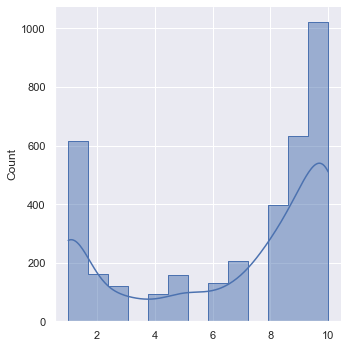

In [41]:
LIST.describe([r for r in grc['rating']])

# Describe variable: rating

• n obs :   158
• mean :   3.5632911392405062
• variance :   10.06921712488914
• std :   3.173202975683897
• min :   1.0
• q25 :   1.0
• q50 :   2.0
• q75 :   6.75
• max :   10.0
• range :   9.0
• skewness :   0.8193751193931578
• kurtosis :   -0.9467107882224961




{'n obs': 158, 'mean': 3.5632911392405062, 'variance': 10.06921712488914, 'std': 3.173202975683897, 'min': 1.0, 'q25': 1.0, 'q50': 2.0, 'q75': 6.75, 'max': 10.0, 'range': 9.0, 'skewness': 0.8193751193931578, 'kurtosis': -0.9467107882224961}

<Figure size 1152x864 with 0 Axes>

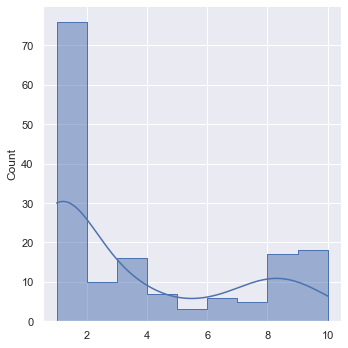

In [251]:
DF.describe(DF.find(xdf, {'bad_dist':['>',0.85]}), 'rating')